# Predicting Real Disaster Tweets with a Wide & Deep Network

A solution to the Kaggle Competition: [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview) - Predict which Tweets are about real disasters and which ones are not.

**Competition Description** (from Kaggle)

Twitter has become an important communication channel in times of emergency.

The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

**Dataset Description** (from Kaggle)

Each sample in the train and test set has the following information:

- The `text` of a tweet
- A `keyword` from that tweet (although this may be blank!)
- The `location` the tweet was sent from (may also be blank)

You are predicting whether a given tweet is about a real disaster or not. If so, predict a `1`. If not, predict a `0`.

- In train.csv only, `target` denotes whether a tweet is about a real disaster (1) or not (0)

**Model Overview**

This solution employs a Wide & Deep architecture:

- Wide Network: A single-layer linear model (logistic regression) leveraging TF-IDF features (1-gram and 2-gram).
- Deep Network: A two-layer Transformer encoding tokenized tweet content.
- The final prediction is a weighted combination of outputs from both networks, aiming to integrate the memorization ability of the wide model with the generalization power of the deep model.

**Preprocessing Steps**

- Concatenate `text`, `keyword`, and `location`.
- Convert to lowercase, remove non-alphabetic characters.
- Remove stopwords and perform lemmatization.
- Calculate TF-IDF features for each tweet.
- Tokenize text: Index `0` reserved for `<PAD>`, `1` for `<UNK>`.

**Evaluation**

Model performance is evaluated using the [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) between the predicted and expected answers, as per the competition guidelines.
  

## Load Necessary Libraries and Resources

In [1]:
import pandas as pd
import numpy as np
import math
import re
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u31/zyang3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/u31/zyang3/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/u31/zyang3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

The training data `train.csv` can be downloaded from [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data)

I randomly split the data into training and validation sets with an 80:20 ratio.

In [2]:
# Load data
df = pd.read_csv('train.csv')

# Fill NaN with empty string
df['keyword'] = df['keyword'].fillna('')
df['location'] = df['location'].fillna('')

# Concatenate keyword, location, text
df['combined_text'] = df['keyword'] + ' ' + df['location'] + ' ' + df['text']

# Lowercase, remove non-alphabet characters
df['combined_text'] = df['combined_text'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

# Stop words removal and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens), filtered_tokens

df['processed_text'], df['tokens'] = zip(*df['combined_text'].apply(preprocess))

# Train-validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

### TF-IDF Vectorization for the "Wide" Network

In [3]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)  # including word-level 1-gram and 2-gram
tfidf_train = tfidf.fit_transform(train_df['processed_text']).toarray()
tfidf_val = tfidf.transform(val_df['processed_text']).toarray()

### Tokenizer for the "Deep" Network

In [4]:
all_tokens = set(word for tokens in train_df['tokens'] for word in tokens)

# 0: padding, 1: unknown token, others from 2+
word2idx = {word: idx + 2 for idx, word in enumerate(all_tokens)}
word2idx['<PAD>'] = 0  # padding token index
word2idx['<UNK>'] = 1  # unknown token index

def tokens_to_ids(tokens):
    return [word2idx.get(word, 1) for word in tokens]  # 1 is the index for unknown words

# Apply token-to-id conversion
train_token_ids = [tokens_to_ids(tokens) for tokens in train_df['tokens']]
val_token_ids = [tokens_to_ids(tokens) for tokens in val_df['tokens']]

# Pad sequences to fixed length
def pad_sequences(sequences, maxlen=30):
    return np.array([
        seq[:maxlen] + [0] * max(0, maxlen - len(seq)) for seq in sequences
    ])

train_token_ids = pad_sequences(train_token_ids)
val_token_ids = pad_sequences(val_token_ids)

## Dataset Definition

In [5]:
class TweetDataset(Dataset):
    def __init__(self, tfidf_features, token_ids, labels):
        self.tfidf_features = tfidf_features
        self.token_ids = token_ids
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'tfidf': torch.tensor(self.tfidf_features[idx], dtype=torch.float32),
            'tokens': torch.tensor(self.token_ids[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

train_dataset = TweetDataset(tfidf_train, train_token_ids, train_df['target'].values)
val_dataset = TweetDataset(tfidf_val, val_token_ids, val_df['target'].values)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Model Definition

In [6]:
class PositionalEncoding(nn.Module):
    # modified from https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch/notebook
    def __init__(self, embed_dim, max_len=30):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)  # even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # odd indices
        pe = pe.unsqueeze(1)  # shape: (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)  # not trainable

    def forward(self, x):
        """
        x: (seq_len, batch_size, embed_dim)
        """
        seq_len = x.size(0)
        return x + self.pe[:seq_len]


class WideAndDeepModel(nn.Module):
    def __init__(self, tfidf_dim, vocab_size, embed_dim=64, transformer_layers=2, transformer_heads=4, max_len=30):
        super(WideAndDeepModel, self).__init__()
        # Wide Network
        self.wide = nn.Linear(tfidf_dim, 1)

        # Deep Network
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=transformer_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=transformer_layers)
        self.deep_fc = nn.Linear(embed_dim, 1)

        self.alpha = nn.Parameter(torch.tensor(0.5))  # learnable combination weight

    def forward(self, tfidf_input, token_input):
        wide_out = self.wide(tfidf_input)  # Wide path

        embed = self.embedding(token_input)  # (batch_size, seq_len, embed_dim)
        embed = embed.permute(1, 0, 2)  # (seq_len, batch_size, embed_dim)
        embed = self.pos_encoder(embed)  # Add positional encoding

        transformer_out = self.transformer_encoder(embed)
        transformer_out = transformer_out.mean(dim=0)  # Average pooling
        deep_out = self.deep_fc(transformer_out)  # Deep path

        output = self.alpha * wide_out + (1 - self.alpha) * deep_out
        return torch.sigmoid(output).view(-1)


## Training

The TF-IDF features are highly sparse, so I apply L1 regularization to the Wide network, similar to Lasso Regression, to encourage feature sparsity.

Hyperparameters are fine-tuned using the validation set, which is also used to trigger early stopping during training.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WideAndDeepModel(tfidf_dim=5000, vocab_size=len(word2idx)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # L2 regularization
l1_lambda = 1e-3  #L1 regularization for the wide network only
criterion = nn.BCELoss()

best_f1 = 0
epochs_no_improve = 0
max_epochs = 50
early_stop_patience = 10
best_model_path = 'best_model.pth'

for epoch in range(max_epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
        tfidf_input = batch['tfidf'].to(device)
        token_input = batch['tokens'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(tfidf_input, token_input)
        loss = criterion(outputs, labels)
        
        l1_norm = torch.norm(model.wide.weight, p=1)  # Add L1 Regularization only on Wide Network
        loss = loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for batch in val_loader:
            tfidf_input = batch['tfidf'].to(device)
            token_input = batch['tokens'].to(device)
            labels = batch['label'].to(device)

            outputs = model(tfidf_input, token_input)
            val_preds.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_preds_binary = [1 if p > 0.5 else 0 for p in val_preds]
    f1 = f1_score(val_labels, val_preds_binary)
    print(f"Epoch {epoch+1}, Loss: {np.mean(train_losses):.4f}, Val F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered.")
            break

/home/u31/zyang3/.local/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 0.6927, Val F1: 0.0000
Epoch 2, Loss: 0.6862, Val F1: 0.0000
Epoch 3, Loss: 0.6844, Val F1: 0.0000
Epoch 4, Loss: 0.6858, Val F1: 0.0000
Epoch 5, Loss: 0.6659, Val F1: 0.6194
Epoch 6, Loss: 0.5598, Val F1: 0.6626
Epoch 7, Loss: 0.4666, Val F1: 0.7016
Epoch 8, Loss: 0.4182, Val F1: 0.6948
Epoch 9, Loss: 0.3712, Val F1: 0.7065
Epoch 10, Loss: 0.3404, Val F1: 0.7075
Epoch 11, Loss: 0.3085, Val F1: 0.7078
Epoch 12, Loss: 0.2900, Val F1: 0.7175
Epoch 13, Loss: 0.2749, Val F1: 0.7039
Epoch 14, Loss: 0.2565, Val F1: 0.7159
Epoch 15, Loss: 0.2447, Val F1: 0.7122
Epoch 16, Loss: 0.2307, Val F1: 0.7155
Epoch 17, Loss: 0.2251, Val F1: 0.6904
Epoch 18, Loss: 0.2220, Val F1: 0.7310
Epoch 19, Loss: 0.2074, Val F1: 0.7341
Epoch 20, Loss: 0.2065, Val F1: 0.7303
Epoch 21, Loss: 0.1986, Val F1: 0.7286
Epoch 22, Loss: 0.2045, Val F1: 0.7353
Epoch 23, Loss: 0.2074, Val F1: 0.7296
Epoch 24, Loss: 0.2179, Val F1: 0.6679
Epoch 25, Loss: 0.2146, Val F1: 0.7115
Epoch 26, Loss: 0.2134, Val F1: 0.

## Test

The test data `test.csv` can be downloaded from [Kaggle](https://www.kaggle.com/competitions/nlp-getting-started/data)

Since the true `target` labels for the test set are not publicly available, I submitted my predictions (`submission.csv`) to the [competition](https://www.kaggle.com/competitions/nlp-getting-started/submissions), which evaluated the results and provided the corresponding F1 score. The final F1 score achieved by my Wide & Deep model on the test set is 0.75022.

In [8]:
# Load the test data
test_df = pd.read_csv('test.csv')

# Preprocess the test data (same as train)
test_df['keyword'] = test_df['keyword'].fillna('')
test_df['location'] = test_df['location'].fillna('')
test_df['combined_text'] = test_df['keyword'] + ' ' + test_df['location'] + ' ' + test_df['text']
test_df['combined_text'] = test_df['combined_text'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))
test_df['processed_text'], test_df['tokens'] = zip(*test_df['combined_text'].apply(preprocess))

# TF-IDF transformation (using trained vectorizer)
tfidf_test = tfidf.transform(test_df['processed_text']).toarray()

# Token-to-id conversion
test_token_ids = [tokens_to_ids(tokens) for tokens in test_df['tokens']]
test_token_ids = pad_sequences(test_token_ids)

# Define test dataset and dataloader
class TestDataset(Dataset):
    def __init__(self, tfidf_features, token_ids):
        self.tfidf_features = tfidf_features
        self.token_ids = token_ids

    def __len__(self):
        return len(self.tfidf_features)

    def __getitem__(self, idx):
        return {
            'tfidf': torch.tensor(self.tfidf_features[idx], dtype=torch.float32),
            'tokens': torch.tensor(self.token_ids[idx], dtype=torch.long)
        }

test_dataset = TestDataset(tfidf_test, test_token_ids)
test_loader = DataLoader(test_dataset, batch_size=32)

# Predict using the trained model
model.load_state_dict(torch.load(best_model_path))
model.eval()
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        tfidf_input = batch['tfidf'].to(device)
        token_input = batch['tokens'].to(device)
        outputs = model(tfidf_input, token_input)
        preds = (outputs > 0.5).long().cpu().numpy()  # Convert to 0 or 1
        test_preds.extend(preds)

# Save predictions to CSV
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_preds
})

submission_df.to_csv('submission.csv', index=False)

/tmp/ipykernel_1251283/1927561329.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


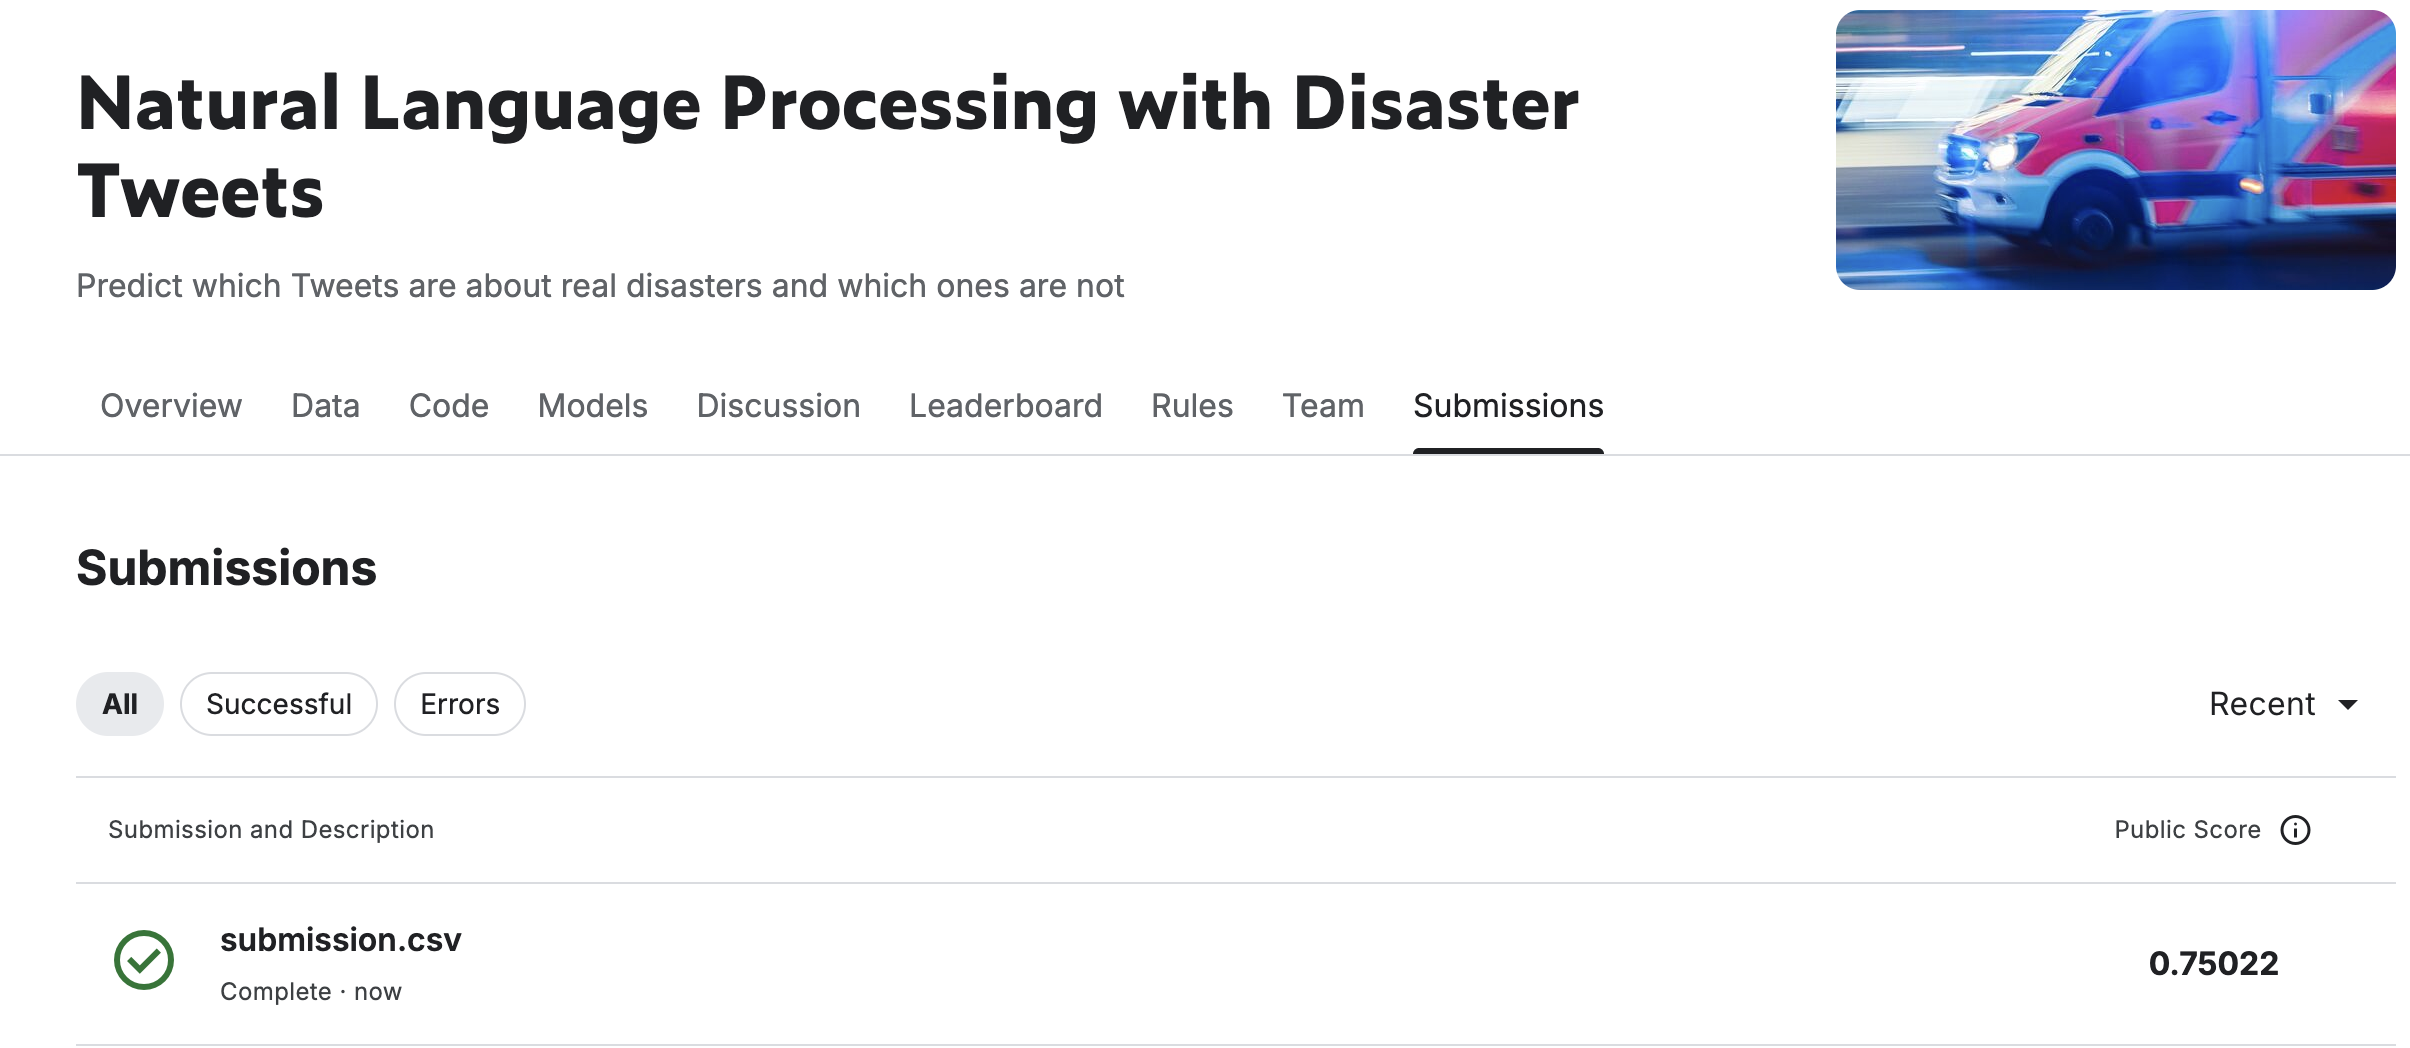